In [ ]:
#!pip install ISLP

Output for every variable and standard 0.5 threshold

1) With SMOTE

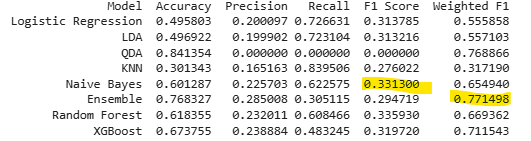

2) With Out CW

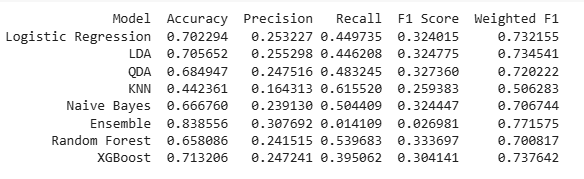

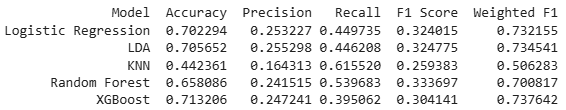

3) Class Weight

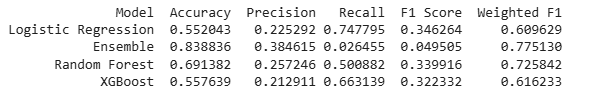

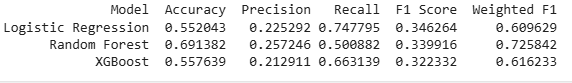

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import mode
from imblearn.over_sampling import SMOTE


In [ ]:
# Load training and test datasets
train_path = "data_train_clean_v5_20250620.csv"
test_path = "data_test_clean_v5_20250620.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Inspect data
print(train_df.head())

   Unnamed: 0  claim_number  age_of_driver gender  marital_status  \
0       16044         22994             32      F               0   
1        1997         18649             40      F               0   
2        5483         29920             48      F               0   
3         760         16506             40      F               0   
4       10001         11820             41      M               1   

   safty_rating  annual_income  high_education_ind  address_change_ind  \
0            61      10.766842                   1                   1   
1            92      11.611893                   1                   1   
2            55      11.543891                   1                   0   
3            78      11.562277                   1                   0   
4            39      10.733000                   1                   1   

  living_status  ...  liab_prct channel policy_report_filed_ind  \
0          Rent  ...          7   Phone                       0   
1     

In [ ]:
print(test_df.head())

   Unnamed: 0  claim_number  age_of_driver gender  marital_status  \
0           1          2759             58      M               1   
1           5         10803             43      F               1   
2          12         19512             59      F               1   
3          17         18874             62      F               1   
4          20         19673             47      M               1   

   safty_rating  annual_income  high_education_ind  address_change_ind  \
0            83      11.670920                   1                   0   
1            84      11.044840                   1                   1   
2            91      11.615599                   1                   1   
3            96      10.930550                   1                   1   
4            53      11.337667                   0                   1   

  living_status  ...  liab_prct channel policy_report_filed_ind  \
0           Own  ...         88  Broker                       0   
1     

In [ ]:
# Check for missing values
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14292 entries, 0 to 14291
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               14292 non-null  int64  
 1   claim_number             14292 non-null  int64  
 2   age_of_driver            14292 non-null  int64  
 3   gender                   14292 non-null  object 
 4   marital_status           14292 non-null  int64  
 5   safty_rating             14292 non-null  int64  
 6   annual_income            14292 non-null  float64
 7   high_education_ind       14292 non-null  int64  
 8   address_change_ind       14292 non-null  int64  
 9   living_status            14292 non-null  object 
 10  zip_code                 14292 non-null  int64  
 11  claim_date               14292 non-null  object 
 12  claim_day_of_week        14292 non-null  object 
 13  accident_site            14292 non-null  object 
 14  past_num_of_claims    

In [ ]:
print(train_df.describe())

         Unnamed: 0  claim_number  age_of_driver  marital_status  \
count  14292.000000  14292.000000   14292.000000    14292.000000   
mean    8923.533935  15034.656871      43.702701        0.711867   
std     5141.344936   8654.860343      11.917643        0.452909   
min        2.000000      1.000000      19.000000        0.000000   
25%     4491.750000   7493.750000      35.000000        0.000000   
50%     8926.500000  15088.500000      43.000000        1.000000   
75%    13363.250000  22482.250000      51.000000        1.000000   
max    17866.000000  29994.000000     200.000000        1.000000   

       safty_rating  annual_income  high_education_ind  address_change_ind  \
count  14292.000000   14292.000000        14292.000000        14292.000000   
mean      73.605793      11.183064            0.702141            0.572628   
std       15.404542       0.394114            0.457333            0.494714   
min        1.000000      10.309486            0.000000            0.000000 

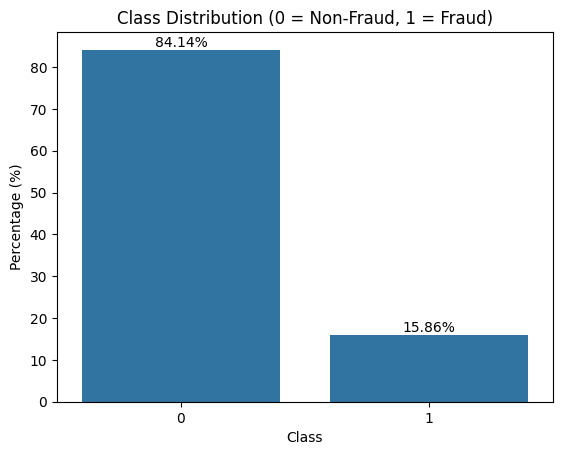

In [ ]:
# train_df
# Calculate the percentage distribution of each class
class_distribution = train_df['fraud'].value_counts(normalize=True) * 100

# Plotting the percentage distribution
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Percentage (%)')

# Adding percentage values on the bars
for i, value in enumerate(class_distribution.values):
    plt.text(i, value + 0.1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

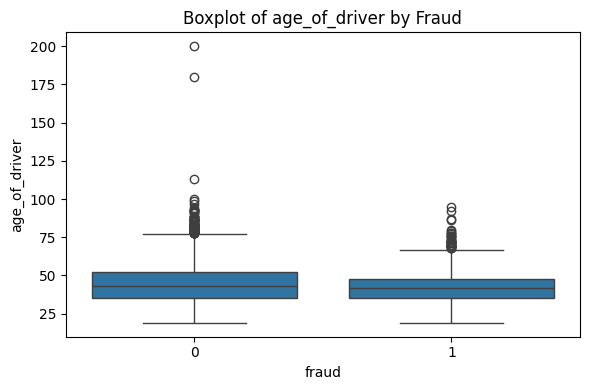

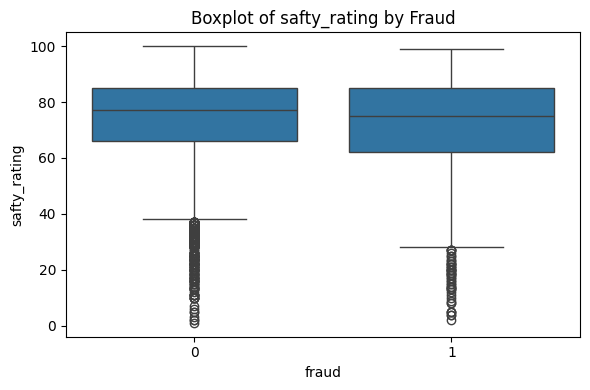

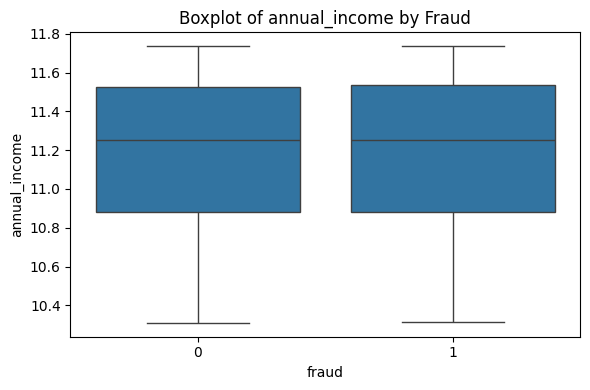

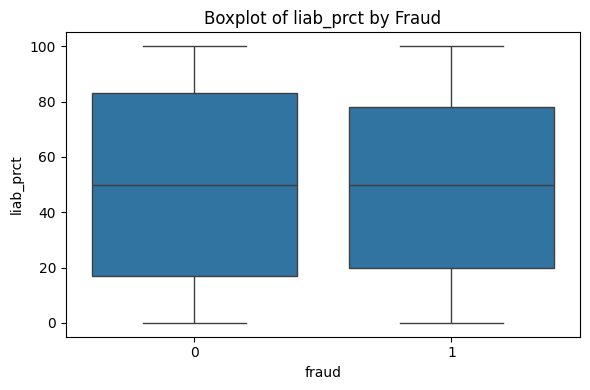

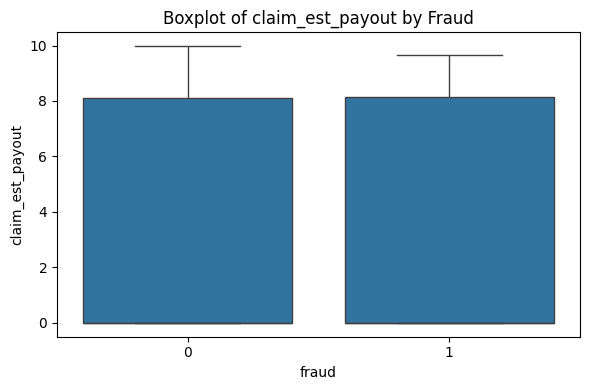

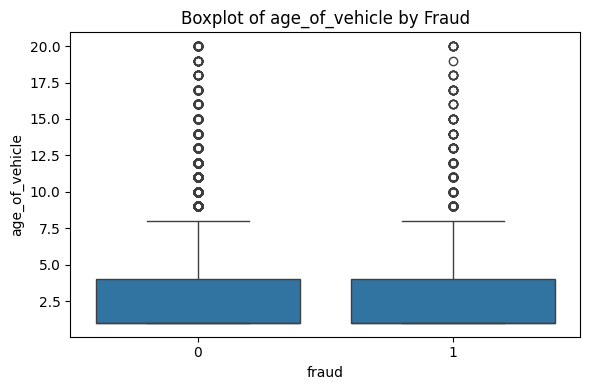

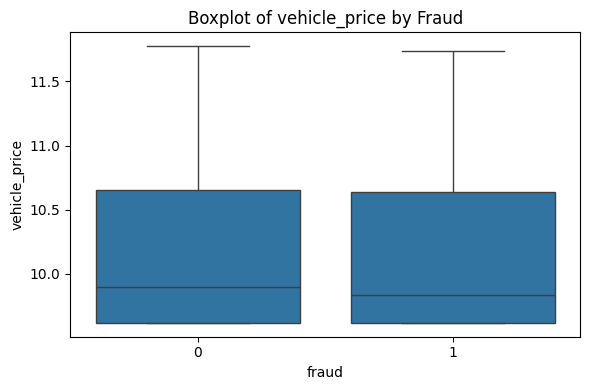

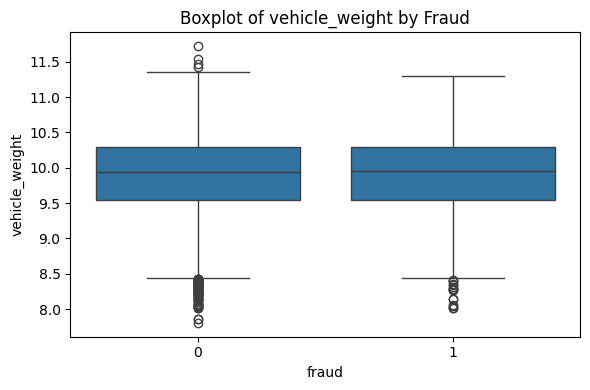

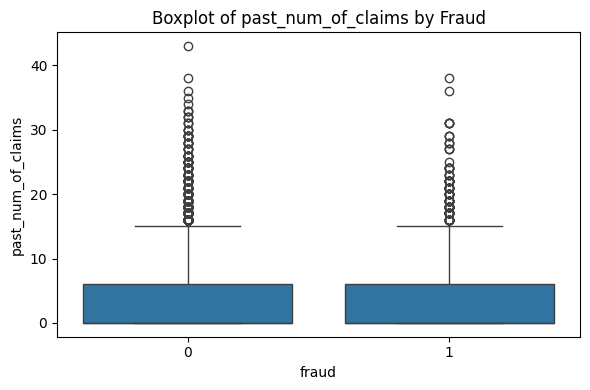

In [ ]:
continuous_cols = ['age_of_driver', 'safty_rating', 'annual_income',
    'liab_prct', 'claim_est_payout', 'age_of_vehicle',
    'vehicle_price', 'vehicle_weight', 'past_num_of_claims']
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data = train_df, x='fraud', y=col)
    plt.title(f"Boxplot of {col} by Fraud")
    plt.tight_layout()
    plt.show()

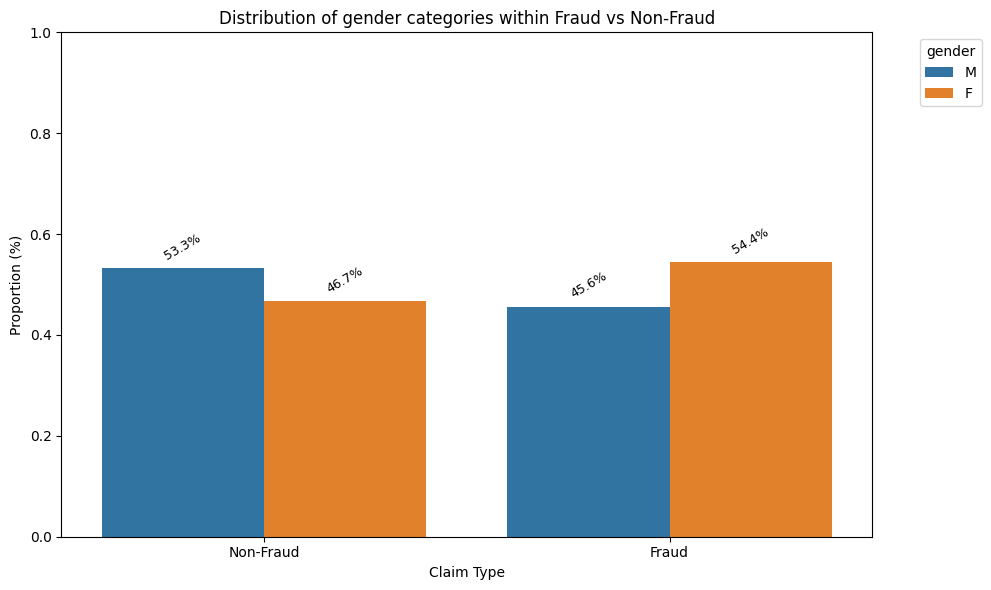

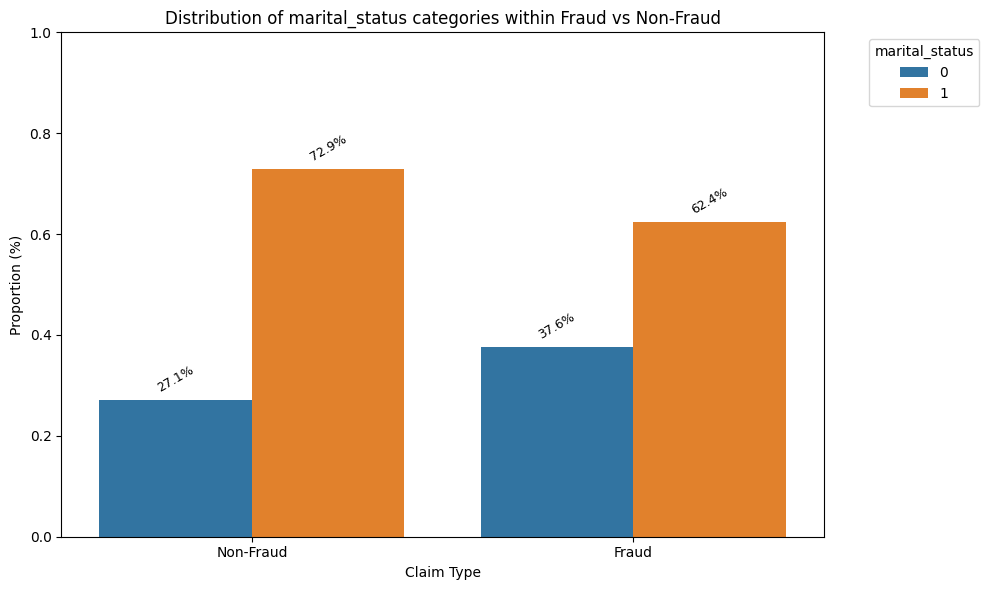

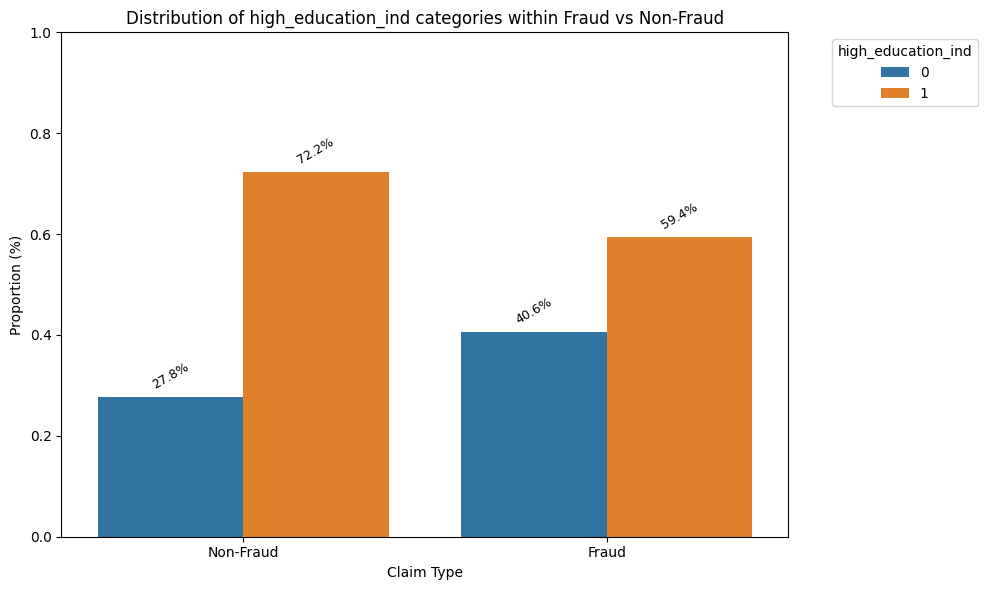

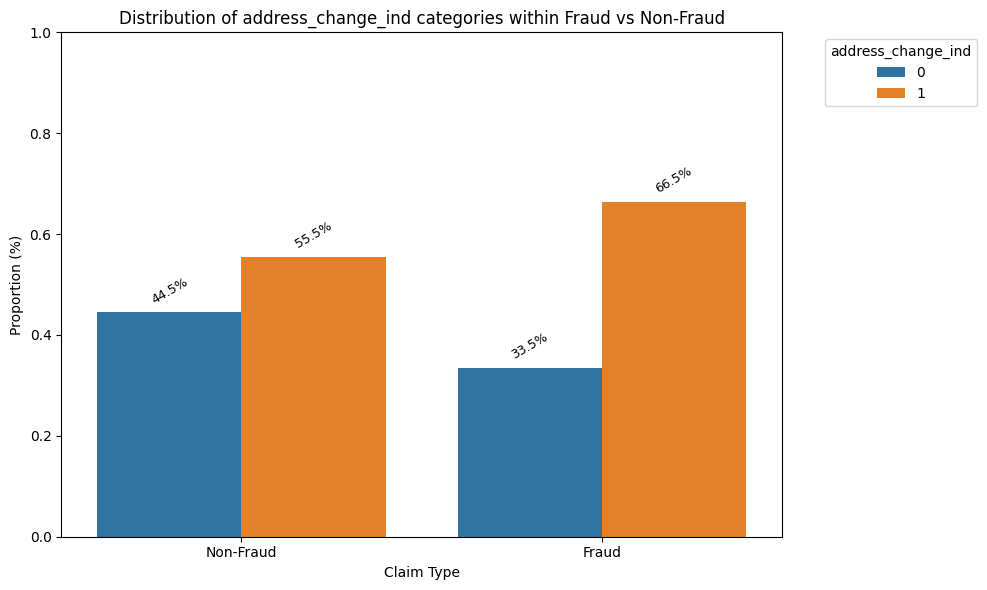

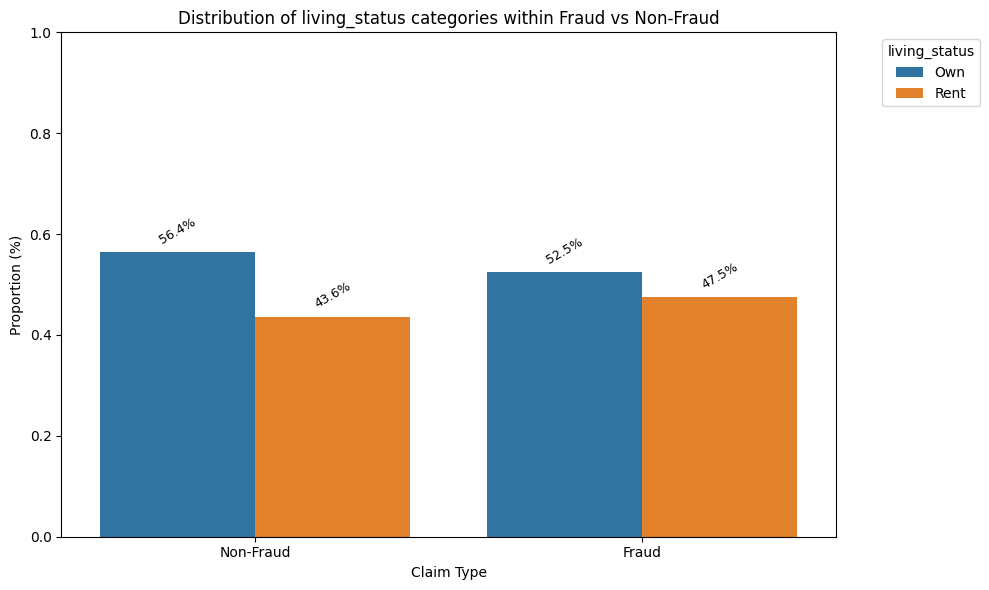

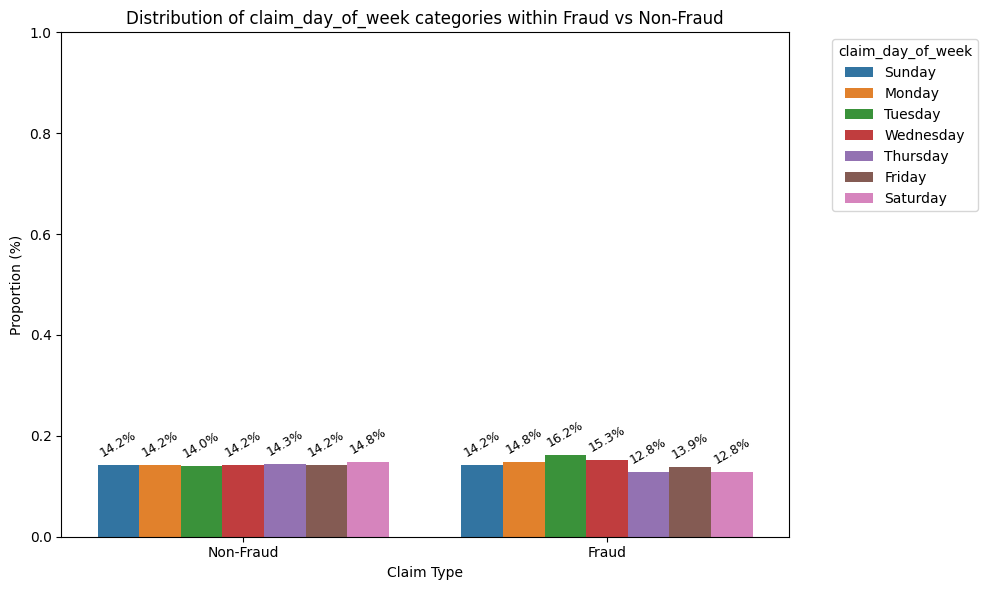

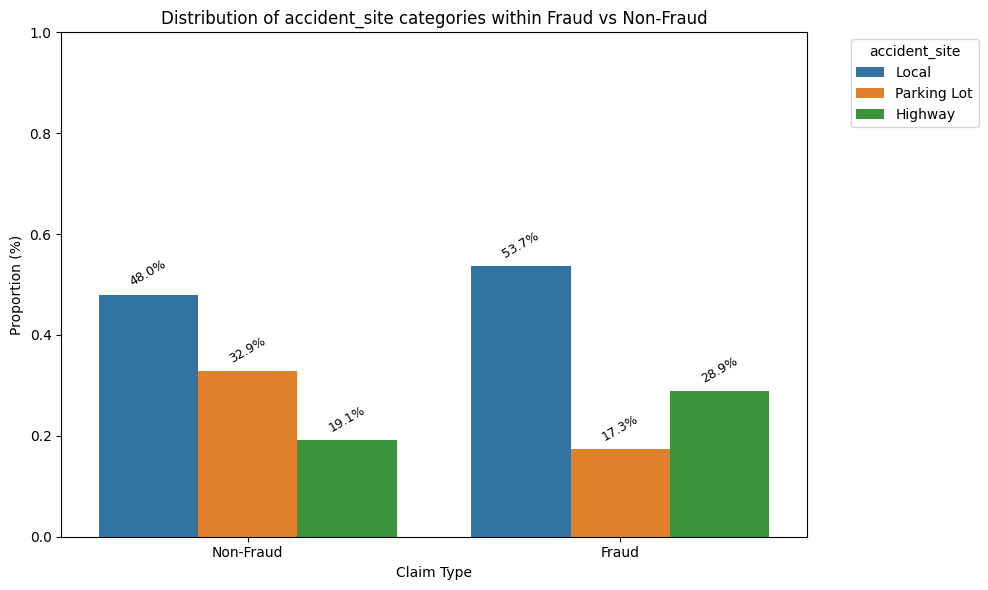

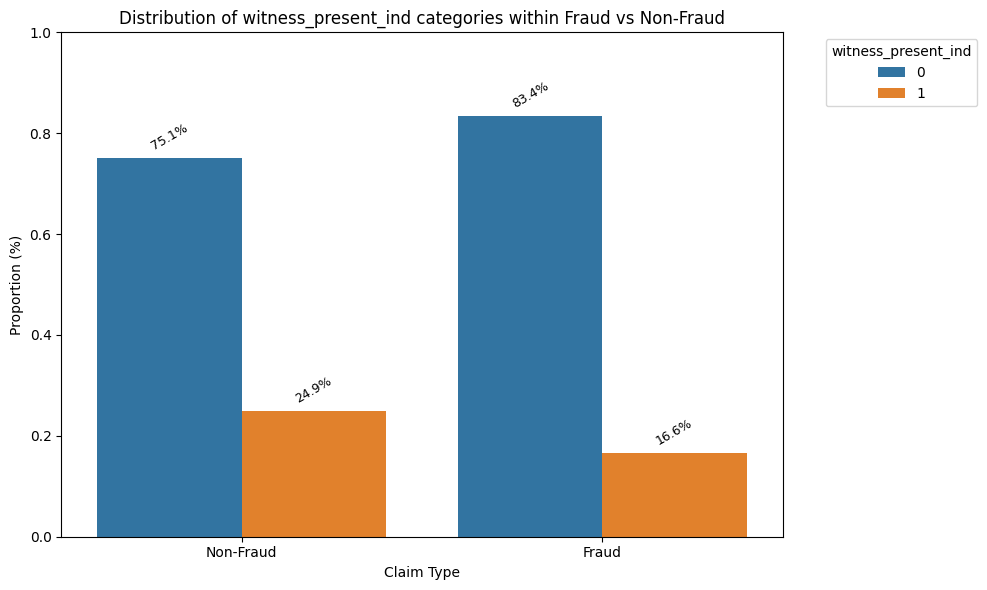

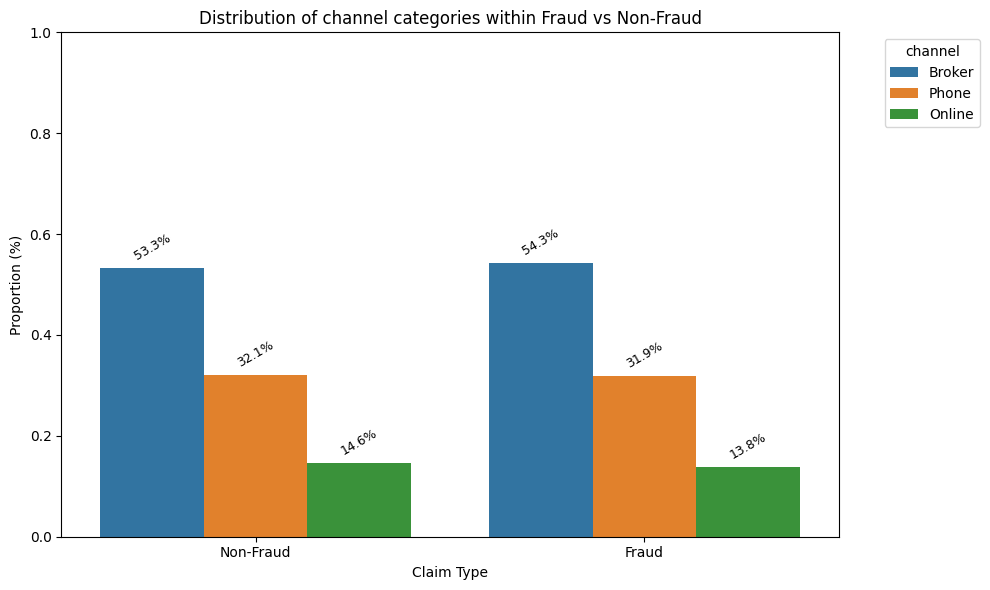

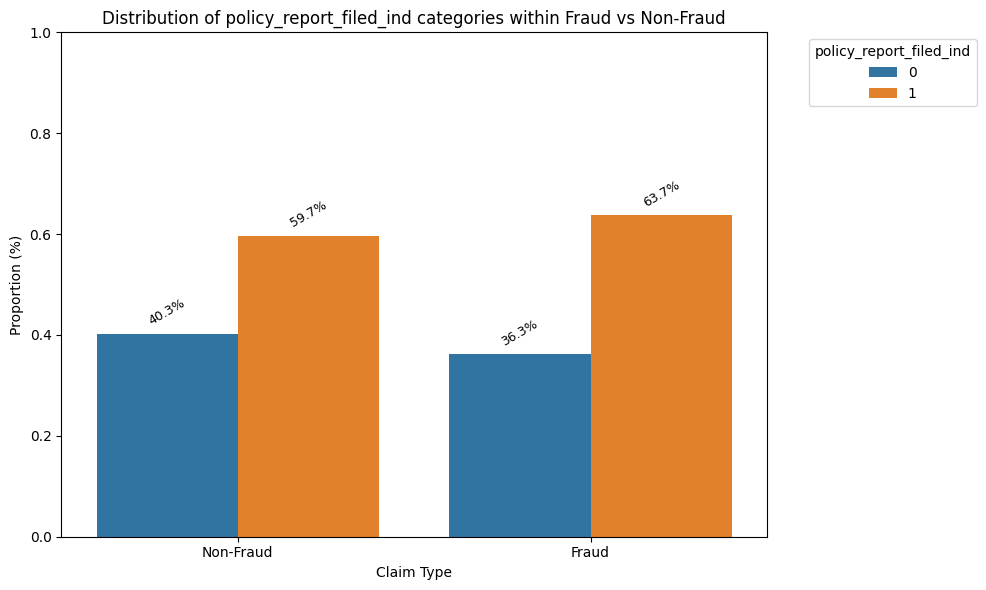

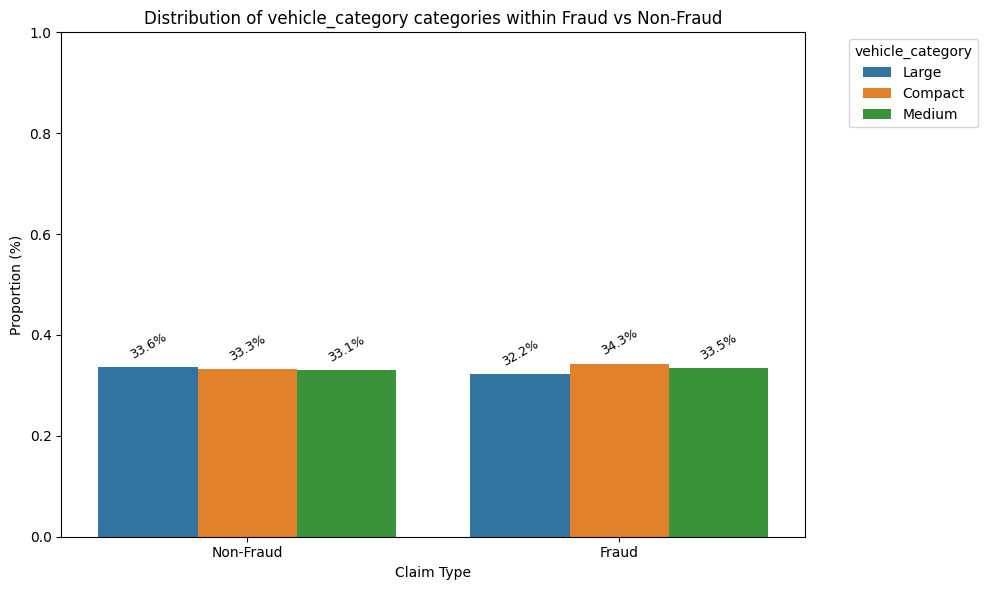

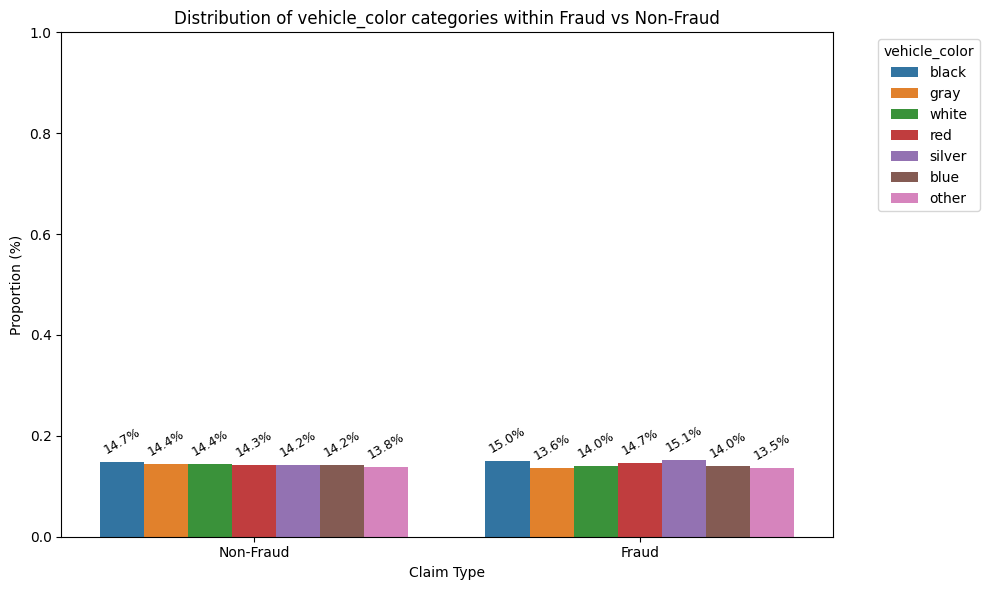

In [ ]:
# Day order for proper weekday alignment
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

discrete_cols = [
    'gender', 'marital_status', 'high_education_ind',
    'address_change_ind', 'living_status', 'claim_day_of_week',
    'accident_site', 'witness_present_ind',
    'channel', 'policy_report_filed_ind', 'vehicle_category', 'vehicle_color'
]

for col in discrete_cols:
    plt.figure(figsize=(10, 6))

    # Compute normalized proportions
    prop_df = (
        train_df.groupby('fraud')[col]
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    # Rename fraud to labels
    prop_df['fraud'] = prop_df['fraud'].map({0: 'Non-Fraud', 1: 'Fraud'})

    # Fix category order if it's claim_day_of_week
    if col == 'claim_day_of_week':
        prop_df[col] = pd.Categorical(prop_df[col], categories=day_order, ordered=True)
        prop_df = prop_df.sort_values([col])

    # Plot
    ax = sns.barplot(data=prop_df, x='fraud', y='proportion', hue=col)

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height*100:.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9,
                        xytext=(0, 4), textcoords='offset points', rotation=30)

    plt.title(f"Distribution of {col} categories within Fraud vs Non-Fraud")
    plt.ylabel("Proportion (%)")
    plt.xlabel("Claim Type")
    plt.ylim(0, 1)
    plt.xticks(fontsize=10)
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


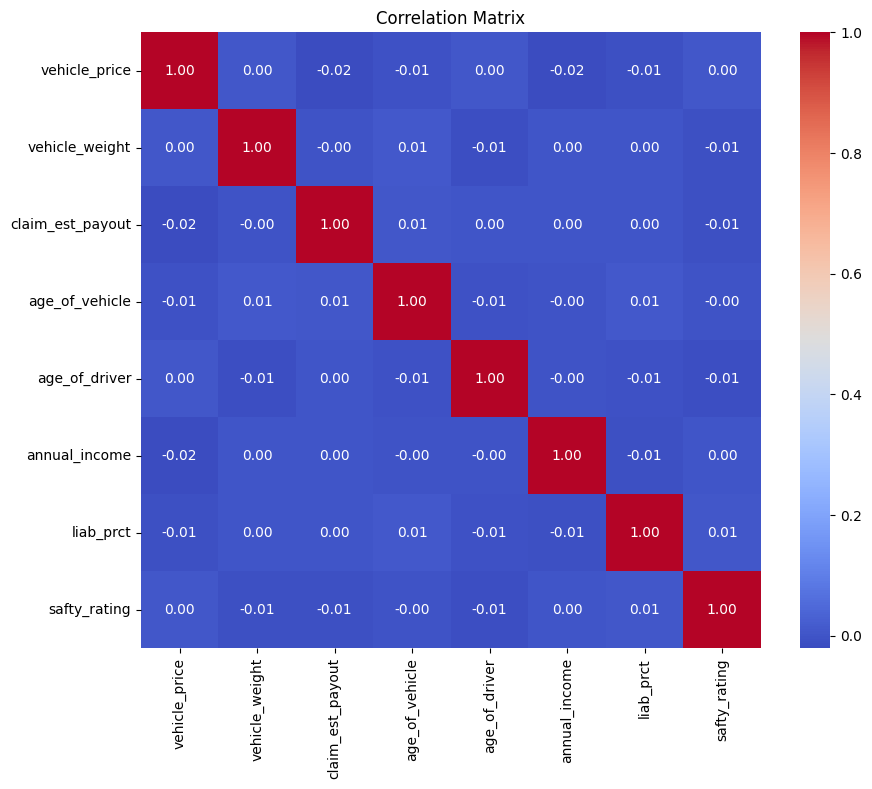

In [ ]:
# Select continuous features to test
features = ['vehicle_price', 'vehicle_weight', 'claim_est_payout', 'age_of_vehicle',
            'age_of_driver', 'annual_income', 'liab_prct', 'safty_rating']

# Compute correlation matrix
corr_matrix = train_df[features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

X = train_df[features].dropna()  # Drop rows with missing values
X = add_constant(X)  # Add intercept for VIF calculation

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

            Feature          VIF
0             const  1494.462819
1     vehicle_price     1.000966
2    vehicle_weight     1.000414
3  claim_est_payout     1.000480
4    age_of_vehicle     1.000318
5     age_of_driver     1.000514
6     annual_income     1.000558
7         liab_prct     1.000407
8      safty_rating     1.000505


In [ ]:
# Drop and transform columns based on analysis

# Drop columns not usable
train_df = train_df.drop(columns=[  'annual_income', 'claim_est_payout','age_of_vehicle', 'living_status',
    'claim_day_of_week', 'vehicle_color','vehicle_weight', 'channel', 'vehicle_category',   'Unnamed: 0', 'claim_number', 'zip_code'])
test_df = test_df.drop(columns=[  'annual_income', 'claim_est_payout', 'age_of_vehicle', 'living_status',
    'claim_day_of_week', 'vehicle_color','vehicle_weight', 'channel', 'vehicle_category',   'Unnamed: 0', 'claim_number', 'zip_code'])

# Transform claim_date to time-based features
train_df['claim_date'] = pd.to_datetime(train_df['claim_date'])
test_df['claim_date'] = pd.to_datetime(test_df['claim_date'])
for df in [train_df, test_df]:
    df['claim_month'] = df['claim_date'].dt.month
    df['claim_dayofyear'] = df['claim_date'].dt.dayofyear
    df['claim_quarter'] = df['claim_date'].dt.quarter

train_df.drop(columns=['claim_date'], inplace=True)
test_df.drop(columns=['claim_date'], inplace=True)

# Cap age_of_driver at 100 in both
median_age = train_df['age_of_driver'].median()
train_df.loc[train_df['age_of_driver'] > 100, 'age_of_driver'] = median_age
test_df.loc[test_df['age_of_driver'] > 100, 'age_of_driver'] = median_age

# Apply log(x+1) transformation
#log_transform_cols = ['annual_income', 'vehicle_price', 'claim_est_payout', 'vehicle_weight']
#for col in log_transform_cols:
 #   if col in train_df.columns:
#        train_df[col] = np.log1p(train_df[col])
 #   if col in test_df.columns:
#        test_df[col] = np.log1p(test_df[col])

# One-hot encode categorical variables
cat_vars = ['gender','accident_site', 'claim_month', 'claim_quarter'
          # ,'claim_day_of_week','vehicle_color', 'gender',  'vehicle_category', 'channel',  'living_status'
            ]
for col in cat_vars:
    if train_df[col].nunique() > 1 and test_df[col].nunique() > 1:
        train_df = pd.get_dummies(train_df, columns=[col], drop_first=True)
        test_df = pd.get_dummies(test_df, columns=[col], drop_first=True)
    else:
        train_df.drop(columns=[col], inplace=True)
        test_df.drop(columns=[col], inplace=True)

# Align columns: keep only columns present in both train and test
common_cols = train_df.columns.intersection(test_df.columns)

# Ensure 'fraud' stays untouched
target_cols = ['fraud']
common_feature_cols = [col for col in common_cols if col not in target_cols]

# Filter both dataframes to common features and target
X_train = train_df[common_feature_cols]
y_train = train_df['fraud']
X_test = test_df[common_feature_cols]
y_test = test_df['fraud']

# Standard scale selected numeric columns (intersected)
scale_cols = [col for col in ['age_of_driver', 'safty_rating', 'liab_prct'] if col in common_feature_cols]
# 'age_of_vehicle'

scaler = StandardScaler()
X_train.loc[:, scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test.loc[:, scale_cols] = scaler.transform(X_test[scale_cols])


/tmp/ipython-input-28-1459284841.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99161109 -0.31226442  0.36708225 ... -0.05750941  0.53691892
  0.79167392]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scale_cols] = scaler.fit_transform(X_train[scale_cols])
/tmp/ipython-input-28-1459284841.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.8183453   1.1941186  -1.20785444 ... -0.23408159  0.22034575
  0.28526394]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scale_cols] = scaler.fit_transform(X_train[scale_cols])
/tmp/ipython-input-28-1459284841.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.27630561  1.03626822 -0.09037031 ...  1.39

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
print(train_df.describe())

       age_of_driver  marital_status  safty_rating  high_education_ind  \
count   14292.000000    14292.000000  14292.000000        14292.000000   
mean       43.677232        0.711867     73.605793            0.702141   
std        11.776432        0.452909     15.404542            0.457333   
min        19.000000        0.000000      1.000000            0.000000   
25%        35.000000        0.000000     65.000000            0.000000   
50%        43.000000        1.000000     76.000000            1.000000   
75%        51.000000        1.000000     85.000000            1.000000   
max       100.000000        1.000000    100.000000            1.000000   

       address_change_ind  past_num_of_claims  witness_present_ind  \
count        14292.000000        14292.000000         14292.000000   
mean             0.572628            3.658480             0.235516   
std              0.494714            5.618141             0.424336   
min              0.000000            0.000000        

In [ ]:
# Train Logistic Regression on SMOTE-resampled data
log_reg_sm = LogisticRegression(max_iter=1000, random_state=42)
log_reg_sm.fit(X_res, y_res)

# Predict probabilities on the original test set
y_proba = log_reg_sm.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []
for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Evaluate at best threshold
logreg_sm = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, logreg_sm))

print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, logreg_sm))


# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, logreg_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3018
Threshold: 0.25, F1 Score: 0.3091
Threshold: 0.30, F1 Score: 0.3138
Threshold: 0.35, F1 Score: 0.3114
Threshold: 0.40, F1 Score: 0.3067
Threshold: 0.45, F1 Score: 0.3073
Threshold: 0.50, F1 Score: 0.3058
Threshold: 0.55, F1 Score: 0.3002
Threshold: 0.60, F1 Score: 0.2889
Threshold: 0.65, F1 Score: 0.2730
Threshold: 0.70, F1 Score: 0.2389
Threshold: 0.75, F1 Score: 0.1935
Threshold: 0.80, F1 Score: 0.1255
Threshold: 0.85, F1 Score: 0.0890
Threshold: 0.90, F1 Score: 0.0398

Best Threshold: 0.30 with F1 Score: 0.3138
Confusion Matrix:
[[1360 1647]
 [ 155  412]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.90      0.45      0.60      3007
           1       0.20      0.73      0.31       567

    accuracy                           0.50      3574
   macro avg       0.55      0.59      0.46      3574
weighted avg       0.79      0.50      0.56      3574

Weighted Average F1 Score: 0.555

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


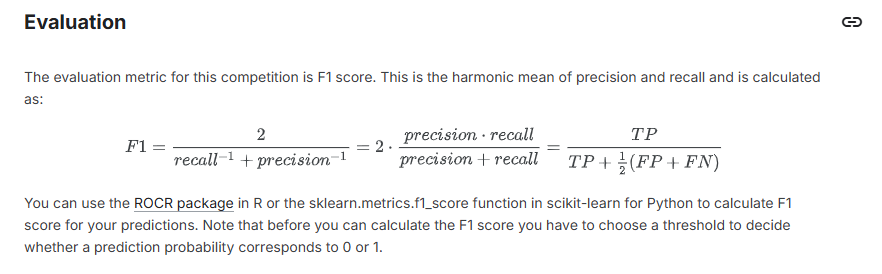

In [ ]:
from sklearn.metrics import confusion_matrix

# Step 1: Apply best threshold
logreg_sm = (y_proba >= best_threshold).astype(int)

# Step 2: Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, logreg_sm).ravel()

# Step 3: Precision and Recall
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# Step 4: Manual F1 Score
if (precision + recall) == 0:
    f1_manual = 0
else:
    f1_manual = 2 * (precision * recall) / (precision + recall)

# Step 5: Output
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
print(f"Manual F1 Score: {f1_manual:.4f}")

TP: 412, FP: 1647, FN: 155, TN: 1360
Precision: 0.2001, Recall: 0.7266
Manual F1 Score: 0.3138


In [ ]:
# Without SMOTE
# Train Logistic Regression on original imbalanced data
log_reg_no_sm = LogisticRegression(max_iter=1000, random_state=42)
log_reg_no_sm.fit(X_train, y_train)

# Predict probabilities on the original test set
y_proba_orig = log_reg_no_sm.predict_proba(X_test)[:, 1]

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_orig = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_orig >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_orig.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx_orig = np.argmax(f1_scores_orig)
best_threshold_orig = thresholds[best_idx_orig]
best_f1_orig = f1_scores_orig[best_idx_orig]

print(f"\nBest Threshold: {best_threshold_orig:.2f} with F1 Score: {best_f1_orig:.4f}")

# Evaluate at best threshold
logreg_no_sm = (y_proba_orig >= best_threshold_orig).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, logreg_no_sm))


print("\nClassification Report at Best Threshold (No SMOTE):")
print(classification_report(y_test, logreg_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, logreg_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")


Threshold: 0.20, F1 Score: 0.3240
Threshold: 0.25, F1 Score: 0.2834
Threshold: 0.30, F1 Score: 0.1916
Threshold: 0.35, F1 Score: 0.1387
Threshold: 0.40, F1 Score: 0.0810
Threshold: 0.45, F1 Score: 0.0434
Threshold: 0.50, F1 Score: 0.0207
Threshold: 0.55, F1 Score: 0.0070
Threshold: 0.60, F1 Score: 0.0000
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000

Best Threshold: 0.20 with F1 Score: 0.3240
Confusion Matrix:
[[2255  752]
 [ 312  255]]

Classification Report at Best Threshold (No SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      3007
           1       0.25      0.45      0.32       567

    accuracy                           0.70      3574
   macro avg       0.57      0.60      0.57      3574
weighted avg       0.78      0.70      0.73      3574

Weighted Average F1 S

In [ ]:
from sklearn.metrics import confusion_matrix

# Step 1: Apply best threshold
logreg_no_sm = (y_proba_orig >= best_threshold_orig).astype(int)

# Step 2: Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, logreg_no_sm).ravel()

# Step 3: Precision and Recall
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# Step 4: Manual F1 Score
if (precision + recall) == 0:
    f1_manual = 0
else:
    f1_manual = 2 * (precision * recall) / (precision + recall)

# Step 5: Output
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
print(f"Manual F1 Score: {f1_manual:.4f}")

TP: 255, FP: 752, FN: 312, TN: 2255
Precision: 0.2532, Recall: 0.4497
Manual F1 Score: 0.3240


In [ ]:
# Train Logistic Regression with class_weight='balanced'
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

#  Predict probabilities on the test set
y_proba_bal = log_reg.predict_proba(X_test)[:, 1]

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_bal = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_bal >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_bal.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx_bal = np.argmax(f1_scores_bal)
best_threshold_bal = thresholds[best_idx_bal]
best_f1_bal = f1_scores_bal[best_idx_bal]

print(f"\nBest Threshold: {best_threshold_bal:.2f} with F1 Score: {best_f1_bal:.4f}")

#  Evaluate at best threshold
logreg_cw = (y_proba_bal >= best_threshold_bal).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, logreg_cw))


print("\nClassification Report at Best Threshold (class_weight='balanced'):")
print(classification_report(y_test, logreg_cw))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, logreg_cw, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")


Threshold: 0.20, F1 Score: 0.2857
Threshold: 0.25, F1 Score: 0.2985
Threshold: 0.30, F1 Score: 0.3115
Threshold: 0.35, F1 Score: 0.3245
Threshold: 0.40, F1 Score: 0.3384
Threshold: 0.45, F1 Score: 0.3463
Threshold: 0.50, F1 Score: 0.3447
Threshold: 0.55, F1 Score: 0.3345
Threshold: 0.60, F1 Score: 0.3141
Threshold: 0.65, F1 Score: 0.2780
Threshold: 0.70, F1 Score: 0.2000
Threshold: 0.75, F1 Score: 0.1377
Threshold: 0.80, F1 Score: 0.0795
Threshold: 0.85, F1 Score: 0.0207
Threshold: 0.90, F1 Score: 0.0000

Best Threshold: 0.45 with F1 Score: 0.3463
Confusion Matrix:
[[1549 1458]
 [ 143  424]]

Classification Report at Best Threshold (class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.92      0.52      0.66      3007
           1       0.23      0.75      0.35       567

    accuracy                           0.55      3574
   macro avg       0.57      0.63      0.50      3574
weighted avg       0.81      0.55      0.61      3574

Weight

In [ ]:
from sklearn.metrics import confusion_matrix

# Step 1: Apply best threshold
logreg_cw = (y_proba_bal >= best_threshold_bal).astype(int)

# Step 2: Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, logreg_cw).ravel()

# Step 3: Precision and Recall
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

# Step 4: Manual F1 Score
if (precision + recall) == 0:
    f1_manual = 0
else:
    f1_manual = 2 * (precision * recall) / (precision + recall)

# Step 5: Output
print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
print(f"Manual F1 Score: {f1_manual:.4f}")

TP: 424, FP: 1458, FN: 143, TN: 1549
Precision: 0.2253, Recall: 0.7478
Manual F1 Score: 0.3463


In [ ]:
# Confusion Matrix for Logistic Regression
#conf_matrix = confusion_matrix(y_test, logreg_cw)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('Logistic Regression Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()


Precision: Out of all samples predicted as fraud (1), how many were truly fraud.
0.83 =
63/(63+13)

Recall: Out of all actual fraud cases, how many were correctly detected.
0.64 = 63/(63+35)

F1-Score: Harmonic mean of precision and recall, balancing both.
0.72 for fraud detection.

Accuracy: The overall percentage of correct predictions.
0.9991 or ~99.91%, which is high due to class imbalance (very few fraud cases compared to non-fraud).

📌 Coefficient Table:

coef (Coefficient): The effect size of each feature. Positive values indicate that an increase in the feature value increases the probability of the positive class, while negative values decrease it.

std err (Standard Error): Indicates the precision of the coefficient estimate. Smaller values suggest more precise estimates.

z: The test statistic, calculated as coef / std err. Higher absolute values indicate stronger evidence against the null hypothesis.

P>|z| (p-value): Indicates statistical significance. Values less than 0.05 generally imply that the predictor is significant.

[0.025 0.975]: The 95% confidence interval for the coefficient. If it crosses zero, the coefficient is not statistically significant.

In [ ]:
# LDA W/ SMOTE
# Train LDA on SMOTE
lda_sm = LDA()
lda_sm.fit(X_res, y_res)

# Step 2: Predict probabilities for class '1' on test set
y_proba_lda = lda_sm.predict_proba(X_test)[:, 1]

# Step 3: Threshold tuning to maximize F1
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_lda = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_lda >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_lda.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Step 4: Best threshold selection
best_idx_lda = np.argmax(f1_scores_lda)
best_threshold_lda = thresholds[best_idx_lda]
best_f1_lda = f1_scores_lda[best_idx_lda]

print(f"\nBest Threshold for LDA: {best_threshold_lda:.2f} with F1 Score: {best_f1_lda:.4f}")

# Step 5: Classification report at best threshold
y_pred_lda = (y_proba_lda >= best_threshold_lda).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

print("\nLDA Classification Report at Best Threshold:")
print(classification_report(y_test, y_pred_lda))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_lda, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3024
Threshold: 0.25, F1 Score: 0.3107
Threshold: 0.30, F1 Score: 0.3132
Threshold: 0.35, F1 Score: 0.3123
Threshold: 0.40, F1 Score: 0.3048
Threshold: 0.45, F1 Score: 0.3066
Threshold: 0.50, F1 Score: 0.3046
Threshold: 0.55, F1 Score: 0.2996
Threshold: 0.60, F1 Score: 0.2981
Threshold: 0.65, F1 Score: 0.2762
Threshold: 0.70, F1 Score: 0.2565
Threshold: 0.75, F1 Score: 0.2054
Threshold: 0.80, F1 Score: 0.1386
Threshold: 0.85, F1 Score: 0.0961
Threshold: 0.90, F1 Score: 0.0525

Best Threshold for LDA: 0.30 with F1 Score: 0.3132
Confusion Matrix:
[[1366 1641]
 [ 157  410]]

LDA Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.90      0.45      0.60      3007
           1       0.20      0.72      0.31       567

    accuracy                           0.50      3574
   macro avg       0.55      0.59      0.46      3574
weighted avg       0.79      0.50      0.56      3574

Weighted Average F1 

In [ ]:
# Train LDA on original (imbalanced) training data NO SMOTE
lda2 = LDA()
lda2.fit(X_train, y_train)

# Predict probabilities for class '1' on test set
y_proba_lda = lda2.predict_proba(X_test)[:, 1]

# Threshold tuning to maximize F1
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_lda = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_lda >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_lda.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Best threshold selection
best_idx_lda = np.argmax(f1_scores_lda)
best_threshold_lda = thresholds[best_idx_lda]
best_f1_lda = f1_scores_lda[best_idx_lda]

print(f"\nBest Threshold for LDA: {best_threshold_lda:.2f} with F1 Score: {best_f1_lda:.4f}")

#  Classification report at best threshold
lda_no_sm = (y_proba_lda >= best_threshold_lda).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, lda_no_sm))

print("\nLDA Classification Report at Best Threshold:")
print(classification_report(y_test, lda_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, lda_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")


Threshold: 0.20, F1 Score: 0.3248
Threshold: 0.25, F1 Score: 0.2834
Threshold: 0.30, F1 Score: 0.2073
Threshold: 0.35, F1 Score: 0.1407
Threshold: 0.40, F1 Score: 0.0899
Threshold: 0.45, F1 Score: 0.0433
Threshold: 0.50, F1 Score: 0.0207
Threshold: 0.55, F1 Score: 0.0070
Threshold: 0.60, F1 Score: 0.0000
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000

Best Threshold for LDA: 0.20 with F1 Score: 0.3248
Confusion Matrix:
[[2269  738]
 [ 314  253]]

LDA Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      3007
           1       0.26      0.45      0.32       567

    accuracy                           0.71      3574
   macro avg       0.57      0.60      0.57      3574
weighted avg       0.78      0.71      0.73      3574

Weighted Average F1 

In [ ]:
# Confusion Matrix for LDA
#conf_matrix = confusion_matrix(y_test, y_pred_lda)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('LDA Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

In [ ]:
# SMOTE
# Train QDA on SMOTE
qda_sm = QDA()
qda_sm.fit(X_res, y_res)

# Step 2: Predict probabilities for class '1' on test set
y_proba_qda = qda_sm.predict_proba(X_test)[:, 1]

# Step 3: Threshold tuning to maximize F1
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_qda = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_qda >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_qda.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Step 4: Best threshold selection
best_idx_qda = np.argmax(f1_scores_qda)
best_threshold_qda = thresholds[best_idx_qda]
best_f1_qda = f1_scores_qda[best_idx_qda]

print(f"\nBest Threshold for QDA: {best_threshold_qda:.2f} with F1 Score: {best_f1_qda:.4f}")

# Step 5: Classification report at best threshold
y_pred_qda = (y_proba_qda >= best_threshold_qda).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

print("\nQDA Classification Report at Best Threshold:")
print(classification_report(y_test, y_pred_qda))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_qda, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.0000
Threshold: 0.25, F1 Score: 0.0000
Threshold: 0.30, F1 Score: 0.0000
Threshold: 0.35, F1 Score: 0.0000
Threshold: 0.40, F1 Score: 0.0000
Threshold: 0.45, F1 Score: 0.0000
Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.55, F1 Score: 0.0000
Threshold: 0.60, F1 Score: 0.0000
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000

Best Threshold for QDA: 0.20 with F1 Score: 0.0000
Confusion Matrix:
[[3007    0]
 [ 567    0]]

QDA Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3007
           1       0.00      0.00      0.00       567

    accuracy                           0.84      3574
   macro avg       0.42      0.50      0.46      3574
weighted avg       0.71      0.84      0.77      3574

Weighted Average F1 

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

In [ ]:
# No SMOTE
# Train QDA on original (imbalanced) data
qda2 = QDA()
qda2.fit(X_train, y_train)

# Step 2: Predict probabilities for class '1' on test set
y_proba_qda = qda2.predict_proba(X_test)[:, 1]

# Step 3: Threshold tuning to maximize F1
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_qda = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_qda >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_qda.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Step 4: Best threshold selection
best_idx_qda = np.argmax(f1_scores_qda)
best_threshold_qda = thresholds[best_idx_qda]
best_f1_qda = f1_scores_qda[best_idx_qda]

print(f"\nBest Threshold for QDA: {best_threshold_qda:.2f} with F1 Score: {best_f1_qda:.4f}")

# Step 5: Classification report at best threshold
qda_no_sm = (y_proba_qda >= best_threshold_qda).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, qda_no_sm))

print("\nQDA Classification Report at Best Threshold:")
print(classification_report(y_test, qda_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, qda_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Threshold: 0.20, F1 Score: 0.3274
Threshold: 0.25, F1 Score: 0.3059
Threshold: 0.30, F1 Score: 0.2646
Threshold: 0.35, F1 Score: 0.2391
Threshold: 0.40, F1 Score: 0.2029
Threshold: 0.45, F1 Score: 0.1681
Threshold: 0.50, F1 Score: 0.1328
Threshold: 0.55, F1 Score: 0.1065
Threshold: 0.60, F1 Score: 0.0814
Threshold: 0.65, F1 Score: 0.0459
Threshold: 0.70, F1 Score: 0.0370
Threshold: 0.75, F1 Score: 0.0308
Threshold: 0.80, F1 Score: 0.0104
Threshold: 0.85, F1 Score: 0.0105
Threshold: 0.90, F1 Score: 0.0070

Best Threshold for QDA: 0.20 with F1 Score: 0.3274
Confusion Matrix:
[[2174  833]
 [ 293  274]]

QDA Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      3007
           1       0.25      0.48      0.33       567

    accuracy                           0.68      3574
   macro avg       0.56      0.60      0.56      3574
weighted avg       0.78      0.68      0.72      3574

Weighted Average F1 

In [ ]:
# Confusion Matrix for QDA
#conf_matrix = confusion_matrix(y_test, y_pred_qda)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('QDA Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

In [ ]:
# SMOTE
k_values = range(2, 10)
thresholds = np.arange(0.2, 0.91, 0.05)
best_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_res, y_res)
    y_proba_knn = knn.predict_proba(X_test)[:, 1]

    for threshold in thresholds:
        y_pred_thresh = (y_proba_knn >= threshold).astype(int)

        precision = precision_score(y_test, y_pred_thresh)
        recall = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        accuracy = accuracy_score(y_test, y_pred_thresh)
        avg = (precision + recall + f1) / 3

        best_results.append({
            'k': k,
            'threshold': threshold,
            'accuracy': accuracy,
            'precision_class_1': precision,
            'recall_class_1': recall,
            'f1_score_class_1': f1,
            'avg_metric_class_1': avg
        })

# Convert results to DataFrame
knn_results_df = pd.DataFrame(best_results)

# Find the best k and threshold combination
best_row = knn_results_df.loc[knn_results_df['f1_score_class_1'].idxmax()]
best_k = int(best_row['k'])
best_threshold = best_row['threshold']

print(f"\nBest k: {best_k}, Best Threshold: {best_threshold:.2f}")
print(best_row)

# Final model evaluation at best k and threshold
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_res, y_res)
y_proba_final = final_knn.predict_proba(X_test)[:, 1]
y_pred_knn = (y_proba_final >= best_threshold).astype(int)

print('\nFinal KNN Report (Best k and Threshold):')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_knn, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")


Best k: 9, Best Threshold: 0.20
k                     9.000000
threshold             0.200000
accuracy              0.301343
precision_class_1     0.165163
recall_class_1        0.839506
f1_score_class_1      0.276022
avg_metric_class_1    0.426897
Name: 105, dtype: float64

Final KNN Report (Best k and Threshold):
Confusion Matrix:
[[ 601 2406]
 [  91  476]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.20      0.32      3007
           1       0.17      0.84      0.28       567

    accuracy                           0.30      3574
   macro avg       0.52      0.52      0.30      3574
weighted avg       0.76      0.30      0.32      3574

Accuracy: 0.30134303301622833
Weighted Average F1 Score: 0.3172


In [ ]:
# NO SMOTE
k_values = range(2, 10)
thresholds = np.arange(0.2, 0.91, 0.05)
best_results = []

for k in k_values:
    knn2 = KNeighborsClassifier(n_neighbors=k)
    knn2.fit(X_train, y_train)
    y_proba_knn = knn2.predict_proba(X_test)[:, 1]

    for threshold in thresholds:
        y_pred_thresh = (y_proba_knn >= threshold).astype(int)

        precision = precision_score(y_test, y_pred_thresh)
        recall = recall_score(y_test, y_pred_thresh)
        f1 = f1_score(y_test, y_pred_thresh)
        accuracy = accuracy_score(y_test, y_pred_thresh)
        avg = (precision + recall + f1) / 3

        best_results.append({
            'k': k,
            'threshold': threshold,
            'accuracy': accuracy,
            'precision_class_1': precision,
            'recall_class_1': recall,
            'f1_score_class_1': f1,
            'avg_metric_class_1': avg
        })

# Convert results to DataFrame
knn_results_df = pd.DataFrame(best_results)

# Find the best k and threshold combination
best_row = knn_results_df.loc[knn_results_df['f1_score_class_1'].idxmax()]
best_k = int(best_row['k'])
best_threshold = best_row['threshold']

print(f"\nBest k: {best_k}, Best Threshold: {best_threshold:.2f}")
print(best_row)

# Final model evaluation at best k and threshold
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
y_proba_final = final_knn.predict_proba(X_test)[:, 1]
knn_no_sm = (y_proba_final >= best_threshold).astype(int)

print('\nFinal KNN Report (Best k and Threshold):')
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn_no_sm))
print("Classification Report:")
print(classification_report(y_test, knn_no_sm))
print("Accuracy:", accuracy_score(y_test, knn_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, knn_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


Best k: 5, Best Threshold: 0.20
k                     5.000000
threshold             0.200000
accuracy              0.442361
precision_class_1     0.164313
recall_class_1        0.615520
f1_score_class_1      0.259383
avg_metric_class_1    0.346405
Name: 45, dtype: float64

Final KNN Report (Best k and Threshold):
Confusion Matrix:
[[1232 1775]
 [ 218  349]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.41      0.55      3007
           1       0.16      0.62      0.26       567

    accuracy                           0.44      3574
   macro avg       0.51      0.51      0.41      3574
weighted avg       0.74      0.44      0.51      3574

Accuracy: 0.44236149972020145
Weighted Average F1 Score: 0.5063


In [ ]:
#k_values = range(2, 10)
#metrics_list = []

#for k in k_values:
    #knn = KNeighborsClassifier(n_neighbors=k)
   # knn.fit(X_res, y_res)
   # y_pred = knn.predict(X_test)

    # Get the full classification report as a dict
  #  report = classification_report(y_test, y_pred, output_dict=True)

    # Extract metrics for class '1'
 #   accuracy = accuracy_score(y_test, y_pred)
 #   precision = report['1']['precision']
 #   recall = report['1']['recall']
#    f1 = report['1']['f1-score']
#    avg = (precision + recall + f1) / 3

   # metrics_list.append({
 #       'k': k,
 #       'accuracy': accuracy,
 #       'precision_class_1': precision,
#        'recall_class_1': recall,
#        'f1_score_class_1': f1,
 #       'avg_metric_class_1': avg
#    })

# Create DataFrame to review all results
#metrics_df = pd.DataFrame(metrics_list)
#print(metrics_df)

# Select best k based on highest average metric for class 1
#best_row = metrics_df.loc[metrics_df['avg_metric_class_1'].idxmax()]
#best_k = int(best_row['k'])

#print(f'\nBest k: {best_k} based on best average of accuracy, precision, recall, and F1-score for class 1.')
#print(best_row)

# Final model evaluation
#final_knn = KNeighborsClassifier(n_neighbors=best_k)
#final_knn.fit(X_res, y_res)
#y_pred_knn =  final_knn.predict(X_test)

#print('\nFinal KNN Report:')
#print("Confusion Matrix:")
#print(confusion_matrix(y_test,  y_pred_knn))
#print("Classification Report:")
#print(classification_report(y_test,  y_pred_knn))
#print("Accuracy:", accuracy_score(y_test,y_pred_knn))


In [ ]:
# Confusion Matrix for KNN
#conf_matrix = confusion_matrix(y_test, y_pred_knn)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('KNN Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

In [ ]:
# Naive Bayes W/ SMOTE

# Train Naive Bayes on SMOTE-resampled data
nb_sm = GaussianNB()
nb_sm.fit(X_res, y_res)

#  Predict probabilities on the original test set
y_proba = nb_sm.predict_proba(X_test)[:, 1]  # Probability of class '1'

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

#  Evaluate at best threshold
y_pred_nb = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("\nNaive Bayes Classification Report at Best Threshold:")
print(classification_report(y_test, y_pred_nb))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_nb, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3150
Threshold: 0.25, F1 Score: 0.3205
Threshold: 0.30, F1 Score: 0.3243
Threshold: 0.35, F1 Score: 0.3264
Threshold: 0.40, F1 Score: 0.3275
Threshold: 0.45, F1 Score: 0.3313
Threshold: 0.50, F1 Score: 0.3286
Threshold: 0.55, F1 Score: 0.3178
Threshold: 0.60, F1 Score: 0.3196
Threshold: 0.65, F1 Score: 0.3168
Threshold: 0.70, F1 Score: 0.3021
Threshold: 0.75, F1 Score: 0.2890
Threshold: 0.80, F1 Score: 0.2526
Threshold: 0.85, F1 Score: 0.2051
Threshold: 0.90, F1 Score: 0.1567

Best Threshold: 0.45 with F1 Score: 0.3313
Confusion Matrix:
[[1796 1211]
 [ 214  353]]

Naive Bayes Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      3007
           1       0.23      0.62      0.33       567

    accuracy                           0.60      3574
   macro avg       0.56      0.61      0.52      3574
weighted avg       0.79      0.60      0.65      3574

Weighted Average F1 

In [ ]:
# Naive Bayes W/O SMOTE

# Train Naive Bayes on SMOTE-resampled data
nb2 = GaussianNB()
nb2.fit(X_train, y_train)

#  Predict probabilities on the original test set
y_proba = nb2.predict_proba(X_test)[:, 1]  # Probability of class '1'

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

#  Evaluate at best threshold
nb_no_sm = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_no_sm))

print("\nNaive Bayes Classification Report at Best Threshold:")
print(classification_report(y_test, nb_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, nb_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3244
Threshold: 0.25, F1 Score: 0.3070
Threshold: 0.30, F1 Score: 0.2899
Threshold: 0.35, F1 Score: 0.2318
Threshold: 0.40, F1 Score: 0.2012
Threshold: 0.45, F1 Score: 0.1641
Threshold: 0.50, F1 Score: 0.1220
Threshold: 0.55, F1 Score: 0.0954
Threshold: 0.60, F1 Score: 0.0642
Threshold: 0.65, F1 Score: 0.0433
Threshold: 0.70, F1 Score: 0.0304
Threshold: 0.75, F1 Score: 0.0205
Threshold: 0.80, F1 Score: 0.0173
Threshold: 0.85, F1 Score: 0.0105
Threshold: 0.90, F1 Score: 0.0035

Best Threshold: 0.20 with F1 Score: 0.3244
Confusion Matrix:
[[2097  910]
 [ 281  286]]

Naive Bayes Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      3007
           1       0.24      0.50      0.32       567

    accuracy                           0.67      3574
   macro avg       0.56      0.60      0.55      3574
weighted avg       0.78      0.67      0.71      3574

Weighted Average F1 

In [ ]:
# Confusion Matrix for NB
#conf_matrix = confusion_matrix(y_test, y_pred_nb)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('Naive Bayes Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

In [ ]:
# Random Forest W/ SMOTE
# Train Random Forest on SMOTE-resampled data
rf_model_sm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_sm.fit(X_res, y_res)

# Step 2: Predict probabilities on the original test set
y_proba = rf_model_sm.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Step 3: Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Step 4: Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Step 5: Evaluate at best threshold
y_pred_rf = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, y_pred_rf))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3197
Threshold: 0.25, F1 Score: 0.3280
Threshold: 0.30, F1 Score: 0.3359
Threshold: 0.35, F1 Score: 0.3354
Threshold: 0.40, F1 Score: 0.3252
Threshold: 0.45, F1 Score: 0.2961
Threshold: 0.50, F1 Score: 0.2759
Threshold: 0.55, F1 Score: 0.2562
Threshold: 0.60, F1 Score: 0.2070
Threshold: 0.65, F1 Score: 0.1548
Threshold: 0.70, F1 Score: 0.1194
Threshold: 0.75, F1 Score: 0.0897
Threshold: 0.80, F1 Score: 0.0605
Threshold: 0.85, F1 Score: 0.0235
Threshold: 0.90, F1 Score: 0.0172

Best Threshold: 0.30 with F1 Score: 0.3359
Confusion Matrix:
[[1865 1142]
 [ 222  345]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73      3007
           1       0.23      0.61      0.34       567

    accuracy                           0.62      3574
   macro avg       0.56      0.61      0.53      3574
weighted avg       0.79      0.62      0.67      3574

Weighted Average F1 Score: 0.669

In [ ]:
# Random Forest W/O SMOTE
# Train Random Forest on SMOTE-resampled data
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model2.fit(X_train, y_train)

# Step 2: Predict probabilities on the original test set
y_proba = rf_model2.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Step 3: Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Step 4: Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Step 5: Evaluate at best threshold
rf_no_sm = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_no_sm))

print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, rf_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, rf_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3337
Threshold: 0.25, F1 Score: 0.3216
Threshold: 0.30, F1 Score: 0.2500
Threshold: 0.35, F1 Score: 0.1785
Threshold: 0.40, F1 Score: 0.1103
Threshold: 0.45, F1 Score: 0.0770
Threshold: 0.50, F1 Score: 0.0373
Threshold: 0.55, F1 Score: 0.0105
Threshold: 0.60, F1 Score: 0.0035
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000

Best Threshold: 0.20 with F1 Score: 0.3337
Confusion Matrix:
[[2046  961]
 [ 261  306]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      3007
           1       0.24      0.54      0.33       567

    accuracy                           0.66      3574
   macro avg       0.56      0.61      0.55      3574
weighted avg       0.78      0.66      0.70      3574

Weighted Average F1 Score: 0.700

In [ ]:
# Train Random Forest with class_weight='balanced'
rf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_bal.fit(X_train, y_train)

# Predict probabilities on the test set
y_proba_bal = rf_bal.predict_proba(X_test)[:, 1]

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_bal = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_bal >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_bal.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx_bal = np.argmax(f1_scores_bal)
best_threshold_bal = thresholds[best_idx_bal]
best_f1_bal = f1_scores_bal[best_idx_bal]

print(f"\nBest Threshold: {best_threshold_bal:.2f} with F1 Score: {best_f1_bal:.4f}")

# Evaluate at best threshold
rf_cw = (y_proba_bal >= best_threshold_bal).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_cw))

print("\nClassification Report at Best Threshold (class_weight='balanced'):")
print(classification_report(y_test, rf_cw))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, rf_cw, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

Threshold: 0.20, F1 Score: 0.3399
Threshold: 0.25, F1 Score: 0.3067
Threshold: 0.30, F1 Score: 0.2414
Threshold: 0.35, F1 Score: 0.1794
Threshold: 0.40, F1 Score: 0.1059
Threshold: 0.45, F1 Score: 0.0586
Threshold: 0.50, F1 Score: 0.0172
Threshold: 0.55, F1 Score: 0.0035
Threshold: 0.60, F1 Score: 0.0035
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.70, F1 Score: 0.0000
Threshold: 0.75, F1 Score: 0.0000
Threshold: 0.80, F1 Score: 0.0000
Threshold: 0.85, F1 Score: 0.0000
Threshold: 0.90, F1 Score: 0.0000

Best Threshold: 0.20 with F1 Score: 0.3399
Confusion Matrix:
[[2187  820]
 [ 283  284]]

Classification Report at Best Threshold (class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      3007
           1       0.26      0.50      0.34       567

    accuracy                           0.69      3574
   macro avg       0.57      0.61      0.57      3574
weighted avg       0.79      0.69      0.73      3574

Weight

In [ ]:
# Confusion Matrix for RF
#conf_matrix = confusion_matrix(y_test, y_pred_rf)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('Random Forest Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

In [ ]:
#  Train XGBoost W/ SMOTE
#  Train XGBoost on SMOTE-resampled data
xgb_model_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_sm.fit(X_res, y_res)

#  Predict probabilities on the original test set
y_proba = xgb_model_sm.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Evaluate at best threshold
y_pred_xgb = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, y_pred_xgb))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_xgb, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold: 0.20, F1 Score: 0.3193
Threshold: 0.25, F1 Score: 0.3197
Threshold: 0.30, F1 Score: 0.3139
Threshold: 0.35, F1 Score: 0.2875
Threshold: 0.40, F1 Score: 0.2642
Threshold: 0.45, F1 Score: 0.2393
Threshold: 0.50, F1 Score: 0.2158
Threshold: 0.55, F1 Score: 0.1827
Threshold: 0.60, F1 Score: 0.1384
Threshold: 0.65, F1 Score: 0.1016
Threshold: 0.70, F1 Score: 0.0836
Threshold: 0.75, F1 Score: 0.0472
Threshold: 0.80, F1 Score: 0.0331
Threshold: 0.85, F1 Score: 0.0171
Threshold: 0.90, F1 Score: 0.0070

Best Threshold: 0.25 with F1 Score: 0.3197
Confusion Matrix:
[[2134  873]
 [ 293  274]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      3007
           1       0.24      0.48      0.32       567

    accuracy                           0.67      3574
   macro avg       0.56      0.60      0.55      3574
weighted avg       0.78      0.67      0.71      3574

Weighted Average F1 Score: 0.711

In [ ]:
#  Train XGBoost W/O SMOTE
#  Train XGBoost on original data
xgb_model2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model2.fit(X_train, y_train)

#  Predict probabilities on the original test set
y_proba = xgb_model2.predict_proba(X_test)[:, 1]  # Probability for class '1'

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nBest Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")

# Evaluate at best threshold
xgb_no_sm = (y_proba >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_no_sm))

print("\nClassification Report at Best Threshold:")
print(classification_report(y_test, xgb_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, xgb_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold: 0.20, F1 Score: 0.3041
Threshold: 0.25, F1 Score: 0.2780
Threshold: 0.30, F1 Score: 0.2624
Threshold: 0.35, F1 Score: 0.2296
Threshold: 0.40, F1 Score: 0.1974
Threshold: 0.45, F1 Score: 0.1698
Threshold: 0.50, F1 Score: 0.1368
Threshold: 0.55, F1 Score: 0.1079
Threshold: 0.60, F1 Score: 0.0906
Threshold: 0.65, F1 Score: 0.0551
Threshold: 0.70, F1 Score: 0.0302
Threshold: 0.75, F1 Score: 0.0103
Threshold: 0.80, F1 Score: 0.0069
Threshold: 0.85, F1 Score: 0.0035
Threshold: 0.90, F1 Score: 0.0035

Best Threshold: 0.20 with F1 Score: 0.3041
Confusion Matrix:
[[2325  682]
 [ 343  224]]

Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3007
           1       0.25      0.40      0.30       567

    accuracy                           0.71      3574
   macro avg       0.56      0.58      0.56      3574
weighted avg       0.77      0.71      0.74      3574

Weighted Average F1 Score: 0.737

In [ ]:
# XG Boost With scale_pos_weight
#Calculate class imbalance ratio for scale_pos_weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

# Train XGBoost with scale_pos_weight
xgb_bal = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    scale_pos_weight=scale_pos_weight, random_state=42)
xgb_bal.fit(X_train, y_train)

# Predict probabilities on test set
y_proba_xgb = xgb_bal.predict_proba(X_test)[:, 1]

# Tune threshold to maximize F1 score
thresholds = np.arange(0.2, 0.91, 0.05)
f1_scores_xgb = []

for threshold in thresholds:
    y_pred_thresh = (y_proba_xgb >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores_xgb.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

# Identify best threshold
best_idx_xgb = np.argmax(f1_scores_xgb)
best_threshold_xgb = thresholds[best_idx_xgb]
best_f1_xgb = f1_scores_xgb[best_idx_xgb]

print(f"\nBest Threshold: {best_threshold_xgb:.2f} with F1 Score: {best_f1_xgb:.4f}")

# Evaluate at best threshold
xgb_cw = (y_proba_xgb >= best_threshold_xgb).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_cw))

print("\nClassification Report at Best Threshold (XGBoost with scale_pos_weight):")
print(classification_report(y_test, xgb_cw))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, xgb_cw, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:54:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold: 0.20, F1 Score: 0.3156
Threshold: 0.25, F1 Score: 0.3223
Threshold: 0.30, F1 Score: 0.3223
Threshold: 0.35, F1 Score: 0.3161
Threshold: 0.40, F1 Score: 0.3079
Threshold: 0.45, F1 Score: 0.2989
Threshold: 0.50, F1 Score: 0.2884
Threshold: 0.55, F1 Score: 0.2806
Threshold: 0.60, F1 Score: 0.2544
Threshold: 0.65, F1 Score: 0.2352
Threshold: 0.70, F1 Score: 0.2057
Threshold: 0.75, F1 Score: 0.1505
Threshold: 0.80, F1 Score: 0.1104
Threshold: 0.85, F1 Score: 0.0709
Threshold: 0.90, F1 Score: 0.0204

Best Threshold: 0.25 with F1 Score: 0.3223
Confusion Matrix:
[[1617 1390]
 [ 191  376]]

Classification Report at Best Threshold (XGBoost with scale_pos_weight):
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      3007
           1       0.21      0.66      0.32       567

    accuracy                           0.56      3574
   macro avg       0.55      0.60      0.50      3574
weighted avg       0.79      0.56      0.62      3574



In [ ]:
# Confusion Matrix for XGB
#conf_matrix = confusion_matrix(y_test, y_pred_xgb)
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.title('XG Boost Confusion Matrix')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()

<Figure size 1000x600 with 0 Axes>

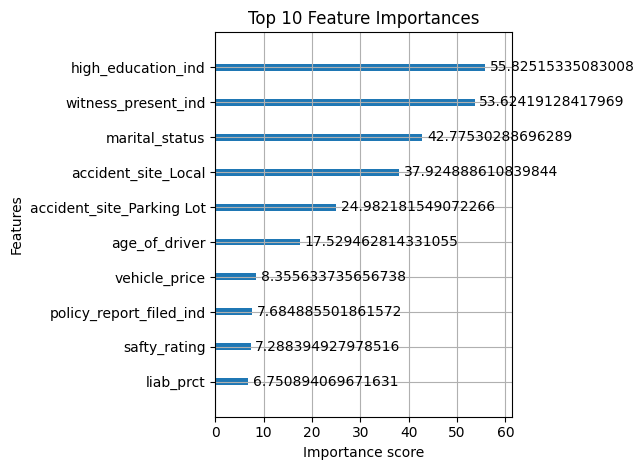

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model_sm, max_num_features=10, importance_type='gain', title="Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# Ensemble Method: Soft Voting Classifier W/ SMOTE
log_reg_sm = LogisticRegression()
#nb_sm = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=k)
#lda_sm = LDA()
#qda_sm = QDA()
rf_model_sm = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg_sm),
    #('nb', nb),
    ('knn', knn),
    #('lda', lda),
    #('qda', qda),
    ('rf', rf_model_sm),
    ('xgb', xgb_model_sm)

], voting='soft')
# Train the ensemble model
voting_clf.fit(X_res, y_res)
# Make predictions
y_pred_ensemble = voting_clf.predict(X_test)
# Evaluate the ensemble model
print("Ensemble Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_ensemble, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Model Evaluation:
Confusion Matrix:
[[2573  434]
 [ 394  173]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3007
           1       0.29      0.31      0.29       567

    accuracy                           0.77      3574
   macro avg       0.58      0.58      0.58      3574
weighted avg       0.77      0.77      0.77      3574

Accuracy: 0.7683268047006155
Weighted Average F1 Score: 0.7715


In [ ]:
# Ensemble Method: Soft Voting Classifier W/O SMOTE
log_reg_no_sm = LogisticRegression()
#nb2 = GaussianNB()
#knn2 = KNeighborsClassifier(n_neighbors=k)
#lda2 = LDA()
#qda2 = QDA()
rf_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model_2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg_no_sm),
    #('nb', nb2),
   #('knn', knn2),
    #('lda', lda2),
    #('qda', qda2),
    ('rf', rf_model_2),
    ('xgb', xgb_model_2)

], voting='soft')
# Train the ensemble model
voting_clf.fit(X_train, y_train)
# Make predictions
ensemble_no_sm = voting_clf.predict(X_test)
# Evaluate the ensemble model
print("Ensemble Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, ensemble_no_sm))
print(classification_report(y_test, ensemble_no_sm))
print("Accuracy:", accuracy_score(y_test, ensemble_no_sm))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, ensemble_no_sm, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Model Evaluation:
Confusion Matrix:
[[2989   18]
 [ 559    8]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3007
           1       0.31      0.01      0.03       567

    accuracy                           0.84      3574
   macro avg       0.58      0.50      0.47      3574
weighted avg       0.76      0.84      0.77      3574

Accuracy: 0.8385562395075545
Weighted Average F1 Score: 0.7716


In [ ]:
# Ensemble Method: Soft Voting Classifier class_weight = balance
log_reg = LogisticRegression()
#rf_bal = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_bal = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
   # ('rf', rf_bal),
    ('xgb', xgb_bal)

], voting='soft')
# Train the ensemble model
voting_clf.fit(X_train, y_train)
# Make predictions
ensemble_cw = voting_clf.predict(X_test)
# Evaluate the ensemble model
print("Ensemble Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, ensemble_cw))
print(classification_report(y_test, ensemble_cw))
print("Accuracy:", accuracy_score(y_test, ensemble_cw))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, ensemble_cw, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Model Evaluation:
Confusion Matrix:
[[2983   24]
 [ 552   15]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3007
           1       0.38      0.03      0.05       567

    accuracy                           0.84      3574
   macro avg       0.61      0.51      0.48      3574
weighted avg       0.77      0.84      0.78      3574

Accuracy: 0.8388360380526021
Weighted Average F1 Score: 0.7751


In [ ]:
# Model Evaluation
# Store all models' predictions and evaluate them W/ SMOTE
models = {
    "Logistic Regression": logreg_sm,
    "LDA": y_pred_lda,
    "QDA": y_pred_qda,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "Ensemble": y_pred_ensemble,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

results = [] # List to store evaluation results for each model
for name, y_pred in models.items():
    # Evaluate each model by calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report_dict['weighted avg']['f1-score']  # Weighted average F1
    results.append([name, accuracy, precision, recall, f1_score, weighted_f1])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Weighted F1'])
final = print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score  Weighted F1
Logistic Regression  0.495803   0.200097 0.726631  0.313785     0.555858
                LDA  0.496922   0.199902 0.723104  0.313216     0.557103
                QDA  0.841354   0.000000 0.000000  0.000000     0.768866
                KNN  0.301343   0.165163 0.839506  0.276022     0.317190
        Naive Bayes  0.601287   0.225703 0.622575  0.331300     0.654940
           Ensemble  0.768327   0.285008 0.305115  0.294719     0.771498
      Random Forest  0.618355   0.232011 0.608466  0.335930     0.669362
            XGBoost  0.673755   0.238884 0.483245  0.319720     0.711543


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Model Evaluation
# Store all models' predictions and evaluate them W/O SMOTE
models = {
    "Logistic Regression": logreg_no_sm,
    "LDA": lda_no_sm,
#    "QDA": qda_no_sm,
    "KNN": knn_no_sm,
 #   "Naive Bayes": nb_no_sm,
#    "Ensemble": ensemble_no_sm,
    "Random Forest": rf_no_sm,
    "XGBoost": xgb_no_sm
}

results = [] # List to store evaluation results for each model
for name, y_pred in models.items():
    # Evaluate each model by calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report_dict['weighted avg']['f1-score']  # Weighted average F1
    results.append([name, accuracy, precision, recall, f1_score, weighted_f1])


# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Weighted F1'])
final = print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score  Weighted F1
Logistic Regression  0.702294   0.253227 0.449735  0.324015     0.732155
                LDA  0.705652   0.255298 0.446208  0.324775     0.734541
                KNN  0.442361   0.164313 0.615520  0.259383     0.506283
      Random Forest  0.658086   0.241515 0.539683  0.333697     0.700817
            XGBoost  0.713206   0.247241 0.395062  0.304141     0.737642


In [ ]:
# Model Evaluation
# Store all models' predictions and evaluate them class_weight = balance
models = {
    "Logistic Regression": logreg_cw,
  #  "Ensemble": ensemble_cw,
    "Random Forest": rf_cw,
    "XGBoost": xgb_cw
}

results = [] # List to store evaluation results for each model
for name, y_pred in models.items():
    # Evaluate each model by calculating accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1_score = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    weighted_f1 = report_dict['weighted avg']['f1-score']  # Weighted average F1
    results.append([name, accuracy, precision, recall, f1_score, weighted_f1])

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Weighted F1'])
final = print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score  Weighted F1
Logistic Regression  0.552043   0.225292 0.747795  0.346264     0.609629
      Random Forest  0.691382   0.257246 0.500882  0.339916     0.725842
            XGBoost  0.557639   0.212911 0.663139  0.322332     0.616233


        Deep Learning Method



*   CNN is great for identifying spatial relationships in the input features, making it well-suited for fraud detection with structured data.

        CNN Model: It applies a convolutional layer to the data followed by a fully connected layer, using the ReLU activation and sigmoid for binary classification.

*   RNN explores if there's a time-series or sequence pattern in the transactions, even though this dataset may not naturally represent time steps.

        RNN Model: It uses a recurrent neural network to process sequential data, followed by a fully connected layer and a sigmoid activation for the final prediction.


1. Data Preprocessing


*   Tensor Conversion: Input features (`X_train_scaled`, `X_test_scaled`) and labels (`y_train`, `y_test`) are converted to PyTorch tensors using `torch.tensor()` for compatibility with neural network models.
*   Batching: Both CNN and RNN models use `DataLoader` to efficiently handle data batching. Batches are shuffled during training for better generalization.


2. CNN Model:
Defining the CNN model: The FraudCNN class defines a simple CNN with:

    A 1D convolutional layer (conv1) with 16 output channels, kernel size 3, and padding 1.

    A ReLU activation function.

    A fully connected layer (fc) that reduces the features after the convolution to a single output.

    A sigmoid activation function to output probabilities.

Training the CNN: The CNN is trained using the Adam optimizer and binary cross-entropy loss (BCELoss), iterating over the training data for 10 epochs. For each batch, the gradients are zeroed, the model makes predictions, and the loss is calculated and used for backpropagation to update the model's parameters.

> An epoch in machine learning refers to one complete pass through the entire training dataset during the model training process. In each epoch, the model’s parameters (weights) are adjusted based on the computed errors (or loss) to minimize the difference between predicted and actual outputs. Typically, training a model involves running several epochs to allow the model to learn from the data and improve its performance over time. The number of epochs is a hyperparameter that can be set before training, and more epochs usually lead to better learning, up to a point where overfitting might occur if training continues for too long.



In [ ]:
print(X_res.shape)

(24052, 28)


Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9597 - loss: 1.0887 - val_accuracy: 1.0000 - val_loss: 4.8608e-06
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9433 - loss: 2.1644 - val_accuracy: 1.0000 - val_loss: 1.9082e-04
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9110 - loss: 1.3964 - val_accuracy: 1.0000 - val_loss: 0.0156
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8508 - loss: 0.6233 - val_accuracy: 1.0000 - val_loss: 0.1472


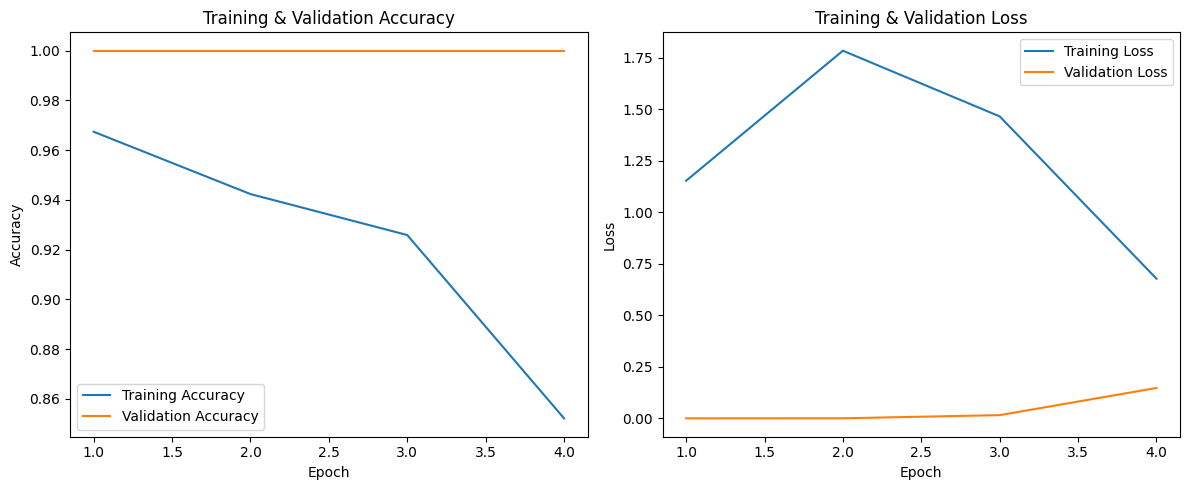

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1513 - loss: 89.4287

 CNN Test Accuracy: 0.1586
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Best Threshold: 0.10 with F1 Score: 0.2738
Confusion Matrix:
[[   0 3007]
 [   0  567]]

 Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3007
         1.0       0.16      1.00      0.27       567

    accuracy                           0.16      3574
   macro avg       0.08      0.50      0.14      3574
weighted avg       0.03      0.16      0.04      3574

CNN Accuracy (sklearn): 0.15864577504196978
Weighted Average F1 Score: 0.0434


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

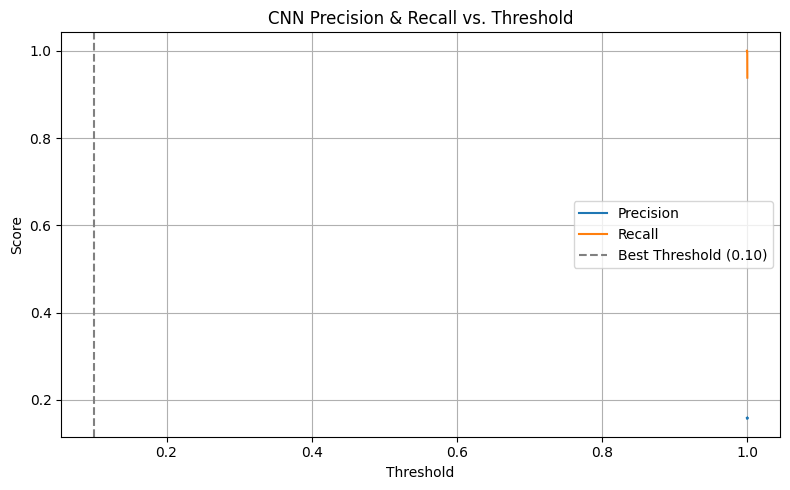

In [ ]:
#  CNN W/ SMOTE
#1. Set seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#  2. CNN model training and evaluation
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_recall_curve

#  3. Reshape and convert data
X_train_cnn = X_res.astype('float32').values.reshape(-1, 28, 1)
X_test_cnn = X_test.astype('float32').values.reshape(-1, 28, 1)
y_train = y_res.astype('float32')
y_test = y_test.astype('float32')

#  4. Define CNN model
cnn_model = models.Sequential([
    Input(shape=(28, 1)),  # 31 features, 1 channel
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

cnn_history = cnn_model.fit(
    X_train_cnn,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    shuffle=False  #  Ensures reproducible shuffling
)

#  5. Plot training history
history = cnn_history.history
epochs_range = range(1, len(history['accuracy']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#  6. Evaluate test accuracy
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f"\n CNN Test Accuracy: {cnn_acc:.4f}")

#  7. Threshold tuning using F1 score
y_pred_probs = cnn_model.predict(X_test_cnn)

best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_pred_probs > thresh).astype('int')
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n Best Threshold: {best_thresh:.2f} with F1 Score: {best_f1:.4f}")

#  8. Classification report
y_pred_cnn = (y_pred_probs > best_thresh).astype('int')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cnn))

print("\n Classification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_cnn))
print("CNN Accuracy (sklearn):", accuracy_score(y_test, y_pred_cnn))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_cnn, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")


#  9. Precision-Recall vs Threshold plot
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(8, 5))
plt.plot(pr_thresholds, precisions[:-1], label='Precision')
plt.plot(pr_thresholds, recalls[:-1], label='Recall')
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.title("CNN Precision & Recall vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3. RNN Model:
  Defining the RNN model: The FraudRNN class defines an RNN with:

    An RNN layer (rnn) with a hidden size of 64.

    A fully connected layer (fc) that converts the RNN's output into a single prediction.

    A sigmoid activation function for binary classification.

    Training the RNN: Similar to the CNN model, the RNN is trained using the Adam optimizer and binary cross-entropy loss, iterating over the training data for 10 epochs.

Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9728 - loss: 0.1692 - val_accuracy: 1.0000 - val_loss: 3.2947e-04
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9503 - loss: 0.1657 - val_accuracy: 1.0000 - val_loss: 5.5214e-04
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9586 - loss: 0.1863 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9382 - loss: 0.2326 - val_accuracy: 1.0000 - val_loss: 0.0035


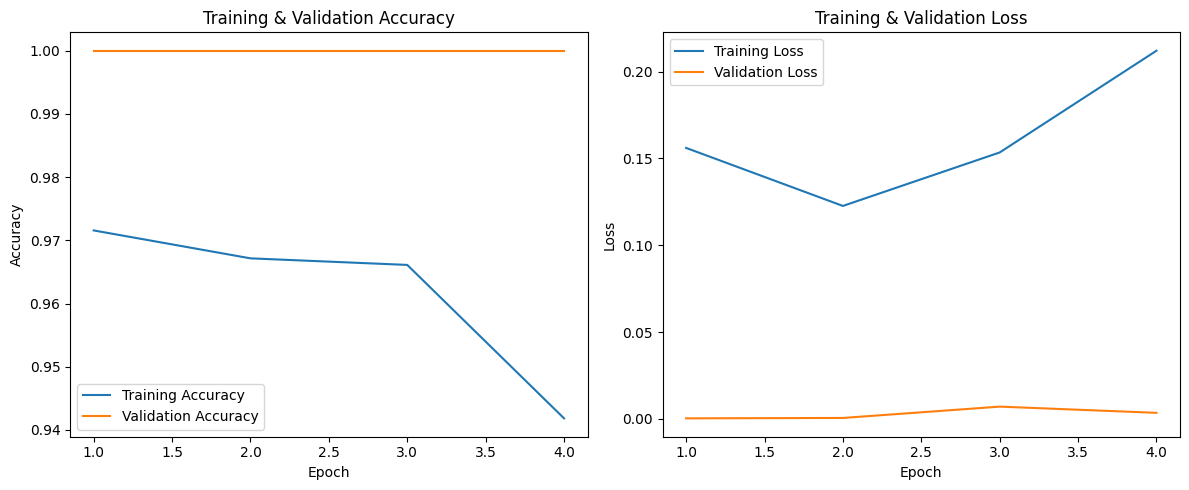

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1513 - loss: 6.8116

 RNN Test Accuracy: 0.1586
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 Best Threshold: 0.10 with F1 Score: 0.2738
Confusion Matrix:
[[   0 3007]
 [   0  567]]

 Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3007
         1.0       0.16      1.00      0.27       567

    accuracy                           0.16      3574
   macro avg       0.08      0.50      0.14      3574
weighted avg       0.03      0.16      0.04      3574

 RNN Accuracy (sklearn): 0.15864577504196978
Weighted Average F1 Score: 0.0434


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

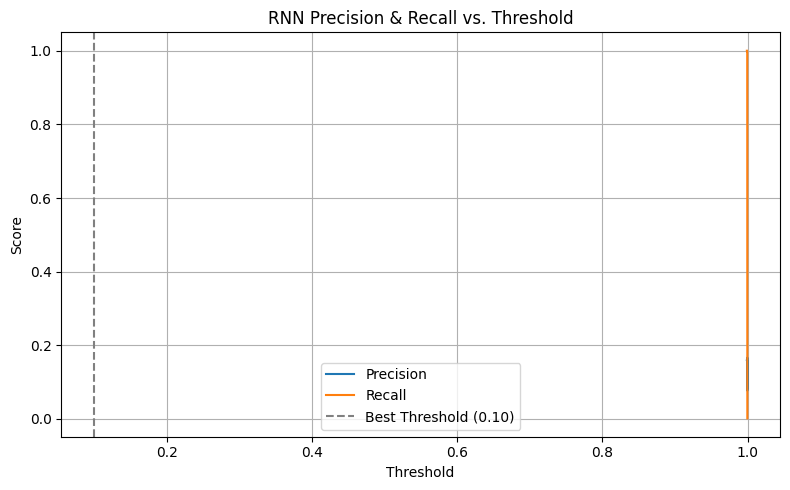

In [ ]:
#  RNN W/ SMOTE
#1. Reproducibility setup
import os
import random
import numpy as np
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#  2. RNN model training and evaluation
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_recall_curve

#  3. Prepare data
X_train_rnn = X_res.astype('float32').values.reshape((X_res.shape[0], X_res.shape[1], 1))
X_test_rnn = X_test.astype('float32').values.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_res.astype('float32')
y_test = y_test.astype('float32')



#  4. Define RNN model
rnn_model = models.Sequential([
    Input(shape=(X_train_rnn.shape[1], 1)),
    layers.SimpleRNN(64, activation='tanh'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

rnn_history = rnn_model.fit(
    X_train_rnn,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    shuffle=False  #  for deterministic output
)

#  5. Plot training history
history = rnn_history.history
epochs_range = range(1, len(history['accuracy']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#  6. Evaluate test set accuracy
rnn_loss, rnn_acc = rnn_model.evaluate(X_test_rnn, y_test)
print(f"\n RNN Test Accuracy: {rnn_acc:.4f}")

#  7. Optimal threshold search via F1 score
y_pred_probs_rnn = rnn_model.predict(X_test_rnn)

best_thresh_rnn = 0.5
best_f1 = 0

for thresh in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_pred_probs_rnn > thresh).astype('int')
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_rnn = thresh

print(f"\n Best Threshold: {best_thresh_rnn:.2f} with F1 Score: {best_f1:.4f}")

#  8. Classification report
y_pred_rnn = (y_pred_probs_rnn > best_thresh_rnn).astype('int')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rnn))

print("\n Classification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_rnn))
print(" RNN Accuracy (sklearn):", accuracy_score(y_test, y_pred_rnn))

# Extract Weighted Average F1 Score
report_dict = classification_report(y_test, y_pred_rnn, output_dict=True)
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"Weighted Average F1 Score: {weighted_f1:.4f}")

#  9. Precision-Recall vs Threshold plot
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_probs_rnn)

plt.figure(figsize=(8, 5))
plt.plot(pr_thresholds, precisions[:-1], label='Precision')
plt.plot(pr_thresholds, recalls[:-1], label='Recall')
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.title("RNN Precision & Recall vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
